# gptv

> Exploring chatgpt_vision for vegan ingredient inferencing.

In [ ]:
#| default_exp ingredient_vision

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import base64
import json
import logging
import os
import time
from glob import glob
from logging.handlers import RotatingFileHandler
from pathlib import Path

import numpy as np
import requests
from PIL import Image

import constants

In [ ]:
#| hide
from dotenv import load_dotenv
from ipywidgets import widgets
import markdown

In [ ]:
#| hide
load_dotenv()
from openai import OpenAI

In [ ]:
logger = logging.getLogger()
logger.handlers.clear()
logger.setLevel(level=logging.DEBUG)
rfh = RotatingFileHandler("/tmp/04_gptv.log", maxBytes=5 * 1024 * 1024, backupCount=5)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
rfh.setFormatter(formatter)
logger.addHandler(rfh)
logging.info("Begin")

In [ ]:
#| export
SAMPLE_IMG_DIR = Path(f"{constants.ROOT_DIR}/assets/images/vegan_ingredients")

Inspiration drawn from [TaskMartix aka Visual ChatGPT](https://github.com/microsoft/TaskMatrix)

In [ ]:
#| export
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
#| export
# fmt: off
def format_image(
    image: str, # Image file path
    size: int = 300
):
    # fmt: on
    img = Image.open(image)
    width, height = img.size
    ratio = min(size / width, size / height)
    width_new, height_new = (round(width * ratio), round(height * ratio))
    width_new = int(np.round(width_new / 64.0)) * 64
    height_new = int(np.round(height_new / 64.0)) * 64
    img = img.resize((width_new, height_new))
    img = img.convert("RGB")
    return img

In [ ]:
sample_images = glob(f"{SAMPLE_IMG_DIR}/*.jpg")
sample_images

['/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/veg-groceries-table.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/fridge-splendid.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/veggie-fridge.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/neat-veg-groceries.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/fruits-and-vegetables-one-a-table.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/veg-groceries-table-2.jpg']

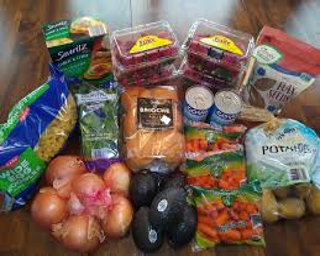

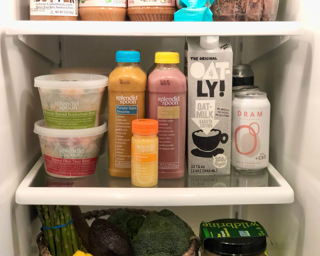

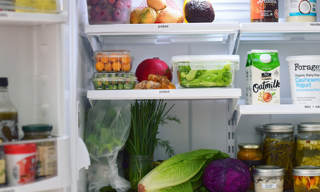

In [ ]:
for img in sample_images[0:3]:
    display(format_image(img))

In [ ]:
client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What vegan ingredients are in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://sweetsimplevegan.com/wp-content/uploads/2019/03/Vegan-Fridge-Tour-Our-Essentials-Sweet-Simple-Vegan-14.jpg",
                    },
                },
            ],
        }
    ],
    max_tokens=300,
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="This image shows a variety of items stored in a refrigerator, several of which appear to be vegan-friendly. Here are some of the vegan ingredients that can be identified:\n\n1. Fresh vegetables: There are several fresh vegetables visible, such as asparagus, kale, cauliflower, carrots, arugula, and possibly salad greens in the crisper drawers.\n\n2. Fresh fruits: Blueberries, strawberries, lemons, and limes are seen, all of which are vegan.\n\n3. Almond milk: On the top shelf, there's a carton that looks like almond milk, a popular dairy milk alternative for vegans.\n\n4. Condiments and sauces: Various condiments which often have vegan options, such as hot sauce, soy sauce, mustard, and what appears to be plant-based mayonnaise.\n\n5. Canned goods: Some canned products are visible, which may include beans or vegetables that are typically vegan.\n\n6. Nuts and seeds: There are containers that seem

<img src="https://sweetsimplevegan.com/wp-content/uploads/2019/03/Vegan-Fridge-Tour-Our-Essentials-Sweet-Simple-Vegan-14.jpg" style="width:300px"/>

In [ ]:
#| eval: false
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
}

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(sample_images[0])}"
                    },
                },
            ],
        }
    ],
    "max_tokens": 300,
}

response = requests.post(
    "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
)
response

<Response [200]>

'The image shows an assortment of grocery items laid out on what seems to be a wooden floor. The items include fresh produce like onions, avocados, and carrots. There are also potatoes in a bag labeled "Potatoes." In addition to the fresh produce, there are packaged goods such as what looks like a bag of pasta or noodles, a packaged loaf of bread, a box that may contain cereal or grain, and two cans, which could contain anything from vegetables to soup. There are also plastic containers that seem to contain fresh fruits like grapes or berries. It represents a typical small grocery haul that could be used to prepare several meals.'

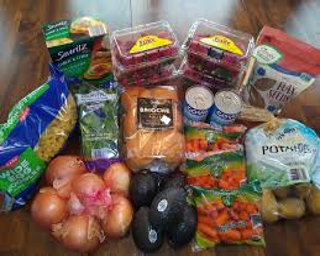

In [ ]:
display(response.json()["choices"][0]["message"]["content"])
display(format_image(sample_images[0]))

In [ ]:
def get_gptv_completion(prompt: str, img: str):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    }

    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{encode_image(img)}"
                        },
                    },
                ],
            }
        ],
        "max_tokens": 300,
    }

    response = requests.post(
        "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
    )
    return response.json()["choices"][0]["message"]["content"]

In [ ]:
get_gptv_completion("What is in this image?", sample_images[0])

"The image shows various food items laid out on a wooden floor. The foods are packaged and fresh produce commonly found in a grocery haul. The visible items include bags of baby carrots, avocados, onions, a bag of pasta, canned goods, possibly some bread, and other packed goods like a container of what may be cherry tomatoes and a package that appears to contain some sort of greens like spinach or mixed lettuce. There's also some packaged cheese visible. These food items suggest someone may have recently returned from shopping and is displaying their purchases."

### Image annotations format from cocodataset
> https://cocodataset.org/#detection-2020 

#### Caption annotation set 2014
```json
{
    "info": {
        "description": "COCO 2014 Dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
    },
    "images": [
        {
            "license": 3,
            "file_name": "COCO_val2014_000000391895.jpg",
            "coco_url": "http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg",
            "height": 360,
            "width": 640,
            "date_captured": "2013-11-14 11:18:45",
            "flickr_url": "http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg",
            "id": 391895
        },
    ]
    "annotations": [
        {
            "image_id": 522418,
            "id": 681330,
            "caption": "A woman wearing a net on her head cutting a cake. "
        },
    ]
```

#### Panoptic 2017 validation set
```json
    "images": [
        {
            "license": 4,
            "file_name": "000000397133.jpg",
            "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
            "height": 427,
            "width": 640,
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
            "id": 397133
        },
        ...
    ]
    "annotations": [
        {"segments_info": [
            {
                "id": 3226956,
                "category_id": 1,
                "iscrowd": 0,
                "bbox": [
                    413,
                    158,
                    53,
                    138
                ],
                "area": 2840
            }]
        "file_name": "000000000139.png",
        "image_id": 139
        }
    ],
    "categories": [
    {
        "supercategory": "person",
        "isthing": 1,
        "id": 1,
        "name": "person"
    },
    ]
```

## Use annotations

In [ ]:
def load_json(f: str):
    with open(f, "r") as file:
        return json.load(file)

In [ ]:
annotations = load_json(f"{SAMPLE_IMG_DIR}/annotations.json")

In [ ]:
annotations["images"][0]

{'file_name': 'fridge-splendid.jpg',
 'ingredients': ['oatmilk',
  'brown rice taco bowl',
  'brocolli',
  'asparagus',
  'avocado',
  'nut butter']}

In [ ]:
vboxes = []
for entry in annotations["images"]:
    image_widget = widgets.Image(
        value=open(f"{SAMPLE_IMG_DIR}/{entry['file_name']}", "rb").read(),
        format="png",
        layout=widgets.Layout(max_width="300px", max_height="300px"),
    )
    desc = widgets.HTML(value=f"<p>{'<br/>'.join(entry['ingredients'])}</p>")
    vbox = widgets.VBox(
        [image_widget, desc],
        layout=widgets.Layout(
            min_width="300px", margin="0px 10px 0px 10px", overflow="hidden"
        ),
    )
    vboxes.append(vbox)

# Combine all VBoxes into a single HBox

hbox = widgets.HBox(vboxes, layout=widgets.Layout(overflow="scroll"))

# Display the final layout
display(hbox)

In [ ]:
# function takes a prompt, tries it on all annotated images, evaluates keywords presence (lowered), ouputs data for analytics
def eval_ingredient_prompt(prompt: str):
    data = []
    for i, entry in enumerate(annotations["images"]):
        logging.info(f"On image {i} of {len(annotations['images'])}")
        msg = get_gptv_completion(prompt, f"{SAMPLE_IMG_DIR}/{entry['file_name']}")
        entry["gptv_completion"] = msg
        data.append(entry)
    return data

In [ ]:
prompt1_data = eval_ingredient_prompt(
    "What vegan ingredients are in the image? Ouput as JSON list."
)

In [ ]:
prompt1_data[0]

{'file_name': 'fridge-splendid.jpg',
 'ingredients': ['oatmilk',
  'brown rice taco bowl',
  'brocolli',
  'asparagus',
  'avocado',
  'nut butter'],
 'gptv_completion': '```json\n[\n  "Moroccan Spiced Buckwheat Bowl",\n  "Pumpkin Spice Smoothie",\n  "Chocolate Pumpkin Smoothie",\n  "Wellness Shot",\n  "Brown Rice Taco Bowl",\n  "Oat Milk",\n  "Asparagus",\n  "Avocado",\n  "Broccoli"\n]\n```'}

In [ ]:
# aggregate analytics of %kwords covered
def analyze_ingredient_results(data):
    metrics = []
    for d in data:
        output_entry = {
            "img": d["file_name"],
            "gptv_completion": d["gptv_completion"],
        }
        ing_checks = {}
        for ing in d["ingredients"]:
            ing_checks[ing] = ing in d["gptv_completion"].lower()

        output_entry["percent_ing_covered"] = round(
            sum(ing_checks.values()) / len(ing_checks.values()) * 100
        )
        output_entry["ingredient_checks"] = ing_checks

        metrics.append(output_entry)
    return metrics


def display_ingredient_results(metrics_data):
    vboxes = []
    for d in metrics_data:
        img = widgets.Image(
            value=open(f"{SAMPLE_IMG_DIR}/{d['img']}", "rb").read(),
            format="png",
            layout=widgets.Layout(max_width="200px", max_height="200px"),
        )
        texts = []
        for ing, is_in_msg in d["ingredient_checks"].items():
            text_color = "red"
            if is_in_msg:
                text_color = "green"

            w_txt = widgets.HTML(value=f"<span>{ing}</span>")
            w_txt.style.text_color = text_color
            texts.append(w_txt)
        w_percent_ing = widgets.HTML(
            value=f"<p style='font-weight: bold;'>Ingredients found: {d['percent_ing_covered']}%</p>"
        )
        w_completion = widgets.HTML(value=markdown.markdown(d['gptv_completion']))
        vbox = widgets.VBox(
            [img, w_percent_ing] + texts + [w_completion],
            layout=widgets.Layout(
                min_width="200px", margin="0px 10px 0px 10px", overflow="hidden"
            ),
        )
        vboxes.append(vbox)

    hbox = widgets.HBox(vboxes, layout=widgets.Layout(overflow="scroll"))
    display(hbox)


display_ingredient_results(analyze_ingredient_results(prompt1_data))

Convert HEIC images (Apple format) to jpg using ImageMagick convert cli
```sh
for file in ./*.HEIC; do convert $file "${file%.HEIC}.jpg"; done 
```


In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()